<a href="https://colab.research.google.com/github/mohitsbh/ds_mohit_bhosale/blob/main/notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10,6)})


2. Load Data

In [3]:
trader = pd.read_csv('/content/csv_files/trader_data.csv')
sentiment = pd.read_csv('/content/csv_files/fear_greed.csv')


/tmp/ipython-input-3077110162.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trader = pd.read_csv('/content/csv_files/trader_data.csv')


In [4]:
print(trader.head())
print(trader.info())
print(sentiment.head())
print(sentiment.info())


                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash  \
0         0.0  0xec09451986a1874e3a9

In [25]:
trader.isnull().sum()
trader['Transaction Hash'].fillna('0x0000000000000000000000000000000000000000000000000000000000000000',inplace=True)
trader['Order ID'].fillna('7.876617e+10',inplace=True)
trader['Crossed'].fillna('True',inplace=True)
trader['Fee'].fillna('0.000000',inplace=True)
trader['Trade ID'].fillna('1.120000e+15',inplace=True)
trader['Timestamp'].fillna('1.740000e+12',inplace=True)


/tmp/ipython-input-1261775445.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trader['Transaction Hash'].fillna('0x0000000000000000000000000000000000000000000000000000000000000000',inplace=True)
/tmp/ipython-input-1261775445.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

Data Cleaning

In [26]:
trader['Timestamp IST'] = pd.to_datetime(
    trader['Timestamp IST'], format="%d-%m-%Y %H:%M"
)

trader['Timestamp'] = pd.to_datetime(
    trader['Timestamp'], unit='ms'
)


In [27]:
sentiment['date'] = pd.to_datetime(sentiment['date'])
trader['date_only'] = trader['Timestamp IST'].dt.date
sentiment['date_only'] = sentiment['date'].dt.date
trader = trader.dropna(how="any")


Merge Dataset

In [28]:
merged = trader.merge(
    sentiment[['date_only','classification']],
    on='date_only',
    how='left'
)



Cleaned Data

In [29]:
merged_clean = merged[[
    'Account',
    'Coin',
    'Execution Price',
    'Size Tokens',
    'Size USD',
    'Side',
    'Timestamp IST',
    'Timestamp',
    'Closed PnL',
    'Fee',
    'Direction',
    'Start Position',
    'date_only',
    'classification'
]]

merged_clean = merged_clean.rename(columns={
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Closed PnL': 'closed_pnl',
    'Timestamp IST': 'timestamp_ist',
})


Profit Flag

In [30]:
merged_clean['profit_flag'] = (merged_clean['closed_pnl'] > 0).astype(int)


Hour

In [31]:
merged_clean['hour'] = merged_clean['timestamp_ist'].dt.hour


Day


In [32]:
merged_clean['day'] = merged_clean['timestamp_ist'].dt.day_name()


EDA ANALYSIS

In [33]:
pnl_sentiment = merged_clean.groupby('classification')['closed_pnl'].mean()
print(pnl_sentiment)


classification
Extreme Fear     33.137939
Extreme Greed    71.051308
Fear             63.568542
Greed            38.354926
Neutral          46.070481
Name: closed_pnl, dtype: float64


In [34]:
lev_sentiment = merged_clean.groupby('classification')['Start Position'].mean()
print(lev_sentiment)


classification
Extreme Fear      -5154.007040
Extreme Greed     21574.880678
Fear              13167.385127
Greed           -185722.208903
Neutral             -81.100603
Name: Start Position, dtype: float64


In [35]:
volume_sentiment = merged_clean.groupby('classification')['size_usd'].sum()
print(volume_sentiment)


classification
Extreme Fear     8.410596e+07
Extreme Greed    1.148746e+08
Fear             4.186532e+08
Greed            2.482131e+08
Neutral          1.535380e+08
Name: size_usd, dtype: float64


In [36]:
buy_sell = merged_clean.groupby(['classification','Side'])['size_usd'].sum()
print(buy_sell)


classification  Side
Extreme Fear    BUY     4.187848e+07
                SELL    4.222748e+07
Extreme Greed   BUY     5.612731e+07
                SELL    5.874733e+07
Fear            BUY     2.125876e+08
                SELL    2.060656e+08
Greed           BUY     1.313852e+08
                SELL    1.168279e+08
Neutral         BUY     6.300164e+07
                SELL    9.053637e+07
Name: size_usd, dtype: float64


Visuals


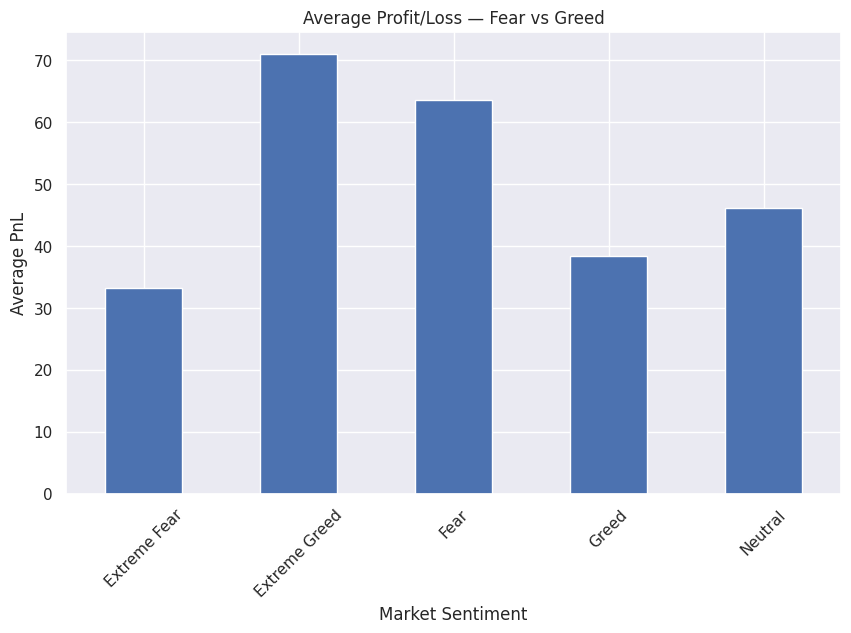

In [37]:
pnl_sentiment.plot(kind='bar')
plt.title("Average Profit/Loss — Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.xticks(rotation=45)
plt.savefig('/content/outputs/pnl_by_sentiment.png', dpi=300)
plt.show()


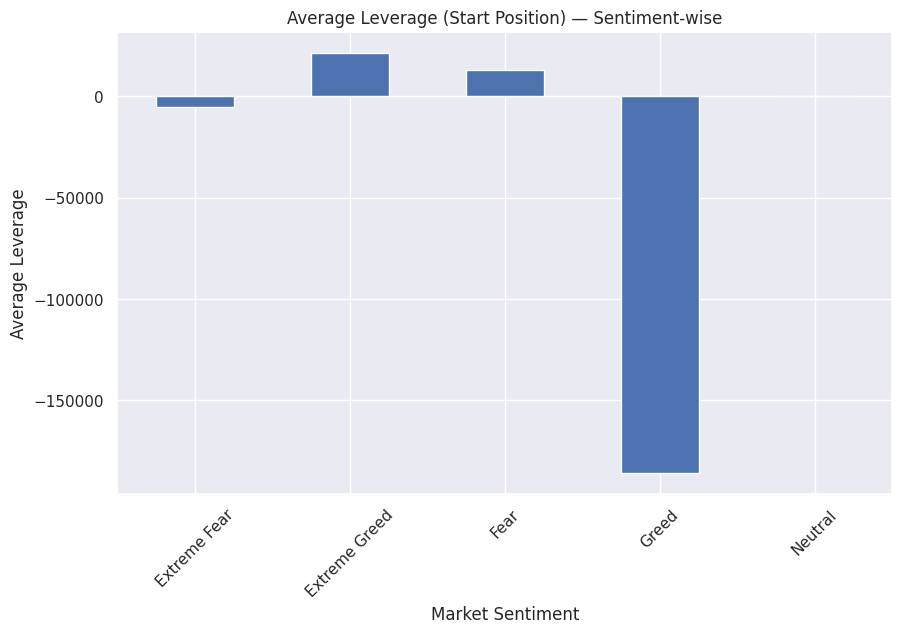

In [38]:
lev_sentiment.plot(kind='bar')
plt.title("Average Leverage (Start Position) — Sentiment-wise")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Leverage")
plt.xticks(rotation=45)
plt.savefig('/content/outputs/leverage_by_sentiment.png', dpi=300)
plt.show()


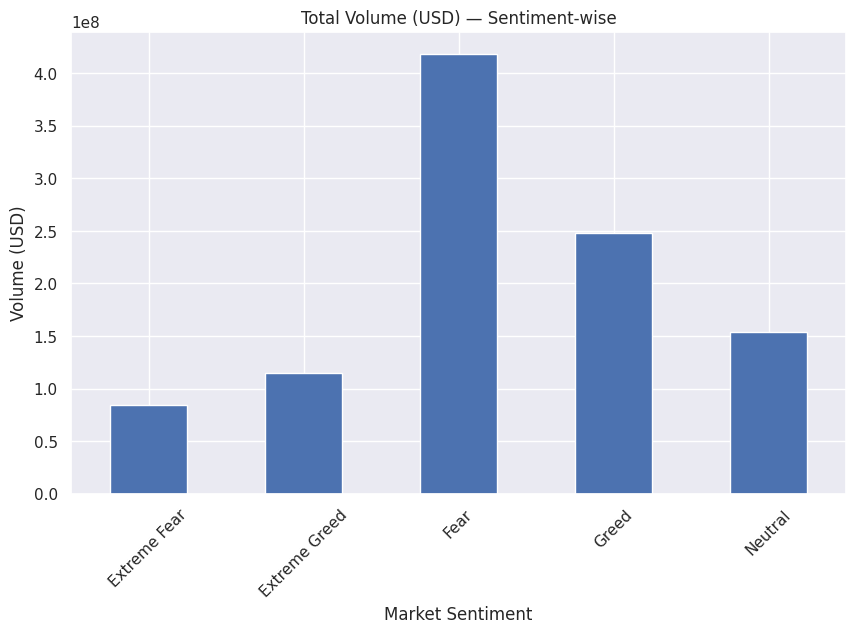

In [39]:
volume_sentiment.plot(kind='bar')
plt.title("Total Volume (USD) — Sentiment-wise")
plt.xlabel("Market Sentiment")
plt.ylabel("Volume (USD)")
plt.xticks(rotation=45)
plt.savefig('/content/outputs/volume_by_sentiment.png', dpi=300)
plt.show()


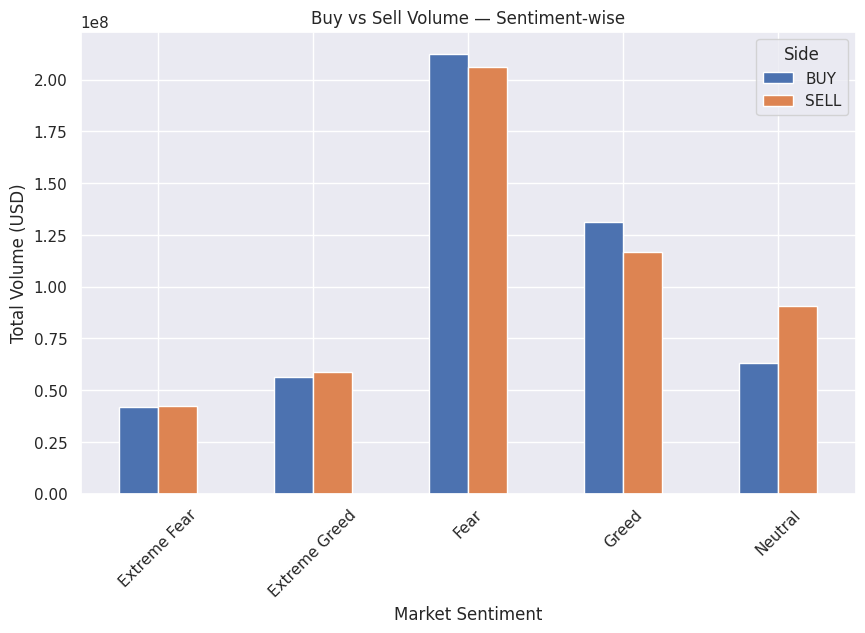

In [40]:
buy_sell_df = merged_clean.groupby(['classification','Side'])['size_usd'].sum().unstack()

buy_sell_df.plot(kind='bar')
plt.title("Buy vs Sell Volume — Sentiment-wise")
plt.xlabel("Market Sentiment")
plt.ylabel("Total Volume (USD)")
plt.xticks(rotation=45)
plt.savefig('/content/outputs/buy_sell_by_sentiment.png', dpi=300)
plt.show()


Correlation Heatmap

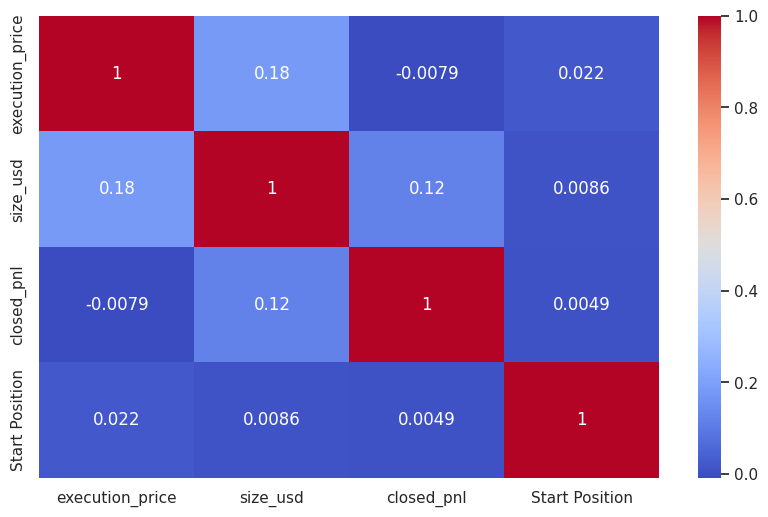

In [41]:
plt.figure(figsize=(10,6))
sns.heatmap(
    merged_clean[['execution_price','size_usd','closed_pnl','Start Position']].corr(),
    annot=True, cmap='coolwarm'
)
plt.savefig('/content/outputs/correlation.png', dpi=300)
plt.show()


In [42]:
summary = {
    "pnl_by_sentiment": pnl_sentiment.to_dict(),
    "leverage_by_sentiment": lev_sentiment.to_dict(),
    "volume_by_sentiment": volume_sentiment.to_dict(),
    "buy_sell": buy_sell.to_dict()
}

summary


{'pnl_by_sentiment': {'Extreme Fear': 33.13793926661264,
  'Extreme Greed': 71.05130821458238,
  'Fear': 63.56854170174362,
  'Greed': 38.3549256873056,
  'Neutral': 46.07048120548044},
 'leverage_by_sentiment': {'Extreme Fear': -5154.007040390665,
  'Extreme Greed': 21574.88067842852,
  'Fear': 13167.385126978048,
  'Greed': -185722.2089028798,
  'Neutral': -81.10060342060018},
 'volume_by_sentiment': {'Extreme Fear': 84105955.88,
  'Extreme Greed': 114874646.55,
  'Fear': 418653233.29,
  'Greed': 248213088.1,
  'Neutral': 153538011.04},
 'buy_sell': {('Extreme Fear', 'BUY'): 41878475.9,
  ('Extreme Fear', 'SELL'): 42227479.98,
  ('Extreme Greed', 'BUY'): 56127314.15,
  ('Extreme Greed', 'SELL'): 58747332.4,
  ('Fear', 'BUY'): 212587607.72,
  ('Fear', 'SELL'): 206065625.57,
  ('Greed', 'BUY'): 131385178.86,
  ('Greed', 'SELL'): 116827909.24,
  ('Neutral', 'BUY'): 63001643.22,
  ('Neutral', 'SELL'): 90536367.82}}